In [28]:
import pandas as pd
import glob
import igraph as ig
import numpy as np
import re
from tqdm import tqdm

In [7]:
# Download associations https://platform.opentargets.org/downloads
!wget --recursive --no-parent --no-host-directories --cut-dirs 8 ftp://ftp.ebi.ac.uk/pub/databases/opentargets/platform/25.09/output/association_by_datasource_direct -P data/open_targets_25_09/association_type


--2025-11-26 00:22:33--  ftp://ftp.ebi.ac.uk/pub/databases/opentargets/platform/25.09/output/association_by_datasource_direct
           => '.listing'
Resolving ftp.ebi.ac.uk (ftp.ebi.ac.uk)... 193.62.193.165
Connecting to ftp.ebi.ac.uk (ftp.ebi.ac.uk)|193.62.193.165|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /pub/databases/opentargets/platform/25.09/output ... done.
==> PASV ... done.    ==> LIST ... done.

.listing                [ <=>                ]   2.90K  --.-KB/s    in 0s      

2025-11-26 00:22:35 (101 MB/s) - '.listing' saved [2965]

Removed '.listing'.
--2025-11-26 00:22:35--  ftp://ftp.ebi.ac.uk/pub/databases/opentargets/platform/25.09/output/association_by_datasource_direct/association_by_datasource_direct
           => '.listing'
==> CWD (1) /pub/databases/opentargets/platform/25.09/output/association_by_datasource_direct ... done.
==> PASV ... done.    ==> LIST ... done.

.listing   

==> PASV ... done.    ==> RETR part-00010-0009005d-4472-49b8-9b32-378935bacdd2-c000.snappy.parquet ... done.
Length: 1482138 (1.4M)

part-00010-0009005d 100%[===================>]   1.41M  5.12MB/s    in 0.3s    

2025-11-26 00:22:40 (5.12 MB/s) - 'part-00010-0009005d-4472-49b8-9b32-378935bacdd2-c000.snappy.parquet' saved [1482138]

--2025-11-26 00:22:40--  ftp://ftp.ebi.ac.uk/pub/databases/opentargets/platform/25.09/output/association_by_datasource_direct/part-00011-0009005d-4472-49b8-9b32-378935bacdd2-c000.snappy.parquet
           => 'part-00011-0009005d-4472-49b8-9b32-378935bacdd2-c000.snappy.parquet'
==> CWD not required.
==> PASV ... done.    ==> RETR part-00011-0009005d-4472-49b8-9b32-378935bacdd2-c000.snappy.parquet ... done.
Length: 1266719 (1.2M)

part-00011-0009005d 100%[===================>]   1.21M  3.89MB/s    in 0.3s    

2025-11-26 00:22:41 (3.89 MB/s) - 'part-00011-0009005d-4472-49b8-9b32-378935bacdd2-c000.snappy.parquet' saved [1266719]

--2025-11-26 00:22:41--  ftp:/

In [29]:
data_dir = "data/open_targets_25_09/association_type/"
df = pd.read_parquet(data_dir, engine="pyarrow")
print(df.head())

         datatypeId       datasourceId    diseaseId         targetId  \
0  affected_pathway  cancer_biomarkers  EFO_0000095  ENSG00000010671   
1  affected_pathway  cancer_biomarkers  EFO_0000095  ENSG00000110848   
2  affected_pathway  cancer_biomarkers  EFO_0000095  ENSG00000165025   
3  affected_pathway  cancer_biomarkers  EFO_0000095  ENSG00000197943   
4  affected_pathway  cancer_biomarkers  EFO_0000178  ENSG00000066468   

      score  evidenceCount  
0  0.607931              1  
1  0.607931              1  
2  0.607931              1  
3  0.607931              1  
4  0.607931              1  


In [30]:
# Remove influence of literature
df = df[df['datatypeId'] != 'literature']
df['datatypeId'].value_counts()

datatypeId
genetic_association    714130
animal_model           690354
rna_expression         166503
somatic_mutation        96504
known_drug              74187
affected_pathway        38121
Name: count, dtype: int64

In [31]:
df

,datatypeId,datasourceId,diseaseId,targetId,score,evidenceCount
0,affected_pathway,cancer_biomarkers,EFO_0000095,ENSG00000010671,0.607931,1
1,affected_pathway,cancer_biomarkers,EFO_0000095,ENSG00000110848,0.607931,1
2,affected_pathway,cancer_biomarkers,EFO_0000095,ENSG00000165025,0.607931,1
3,affected_pathway,cancer_biomarkers,EFO_0000095,ENSG00000197943,0.607931,1
4,affected_pathway,cancer_biomarkers,EFO_0000178,ENSG00000066468,0.607931,1
...,...,...,...,...,...,...
4200230,genetic_association,clingen,Orphanet_93271,ENSG00000118965,0.607931,1
4200231,genetic_association,clingen,Orphanet_93271,ENSG00000119333,0.607931,1
4200232,genetic_association,clingen,Orphanet_93271,ENSG00000126870,0.607931,1
4200233,genetic_association,clingen,Orphanet_98673,ENSG00000100412,0.607931,1


(array([382591., 167076., 418481., 297373., 232721., 115700.,  89880.,
         36295.,  25405.,  14277.]),
 array([0.00607931, 0.10544387, 0.20480843, 0.30417299, 0.40353755,
        0.50290211, 0.60226667, 0.70163123, 0.80099579, 0.90036035,
        0.99972491]),
 <BarContainer object of 10 artists>)

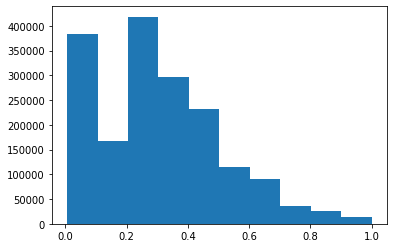

In [32]:
import matplotlib.pyplot as plt
plt.hist(df['score'])

In [33]:
def bounded_harmonic_sum(scores):
    S = scores.sum()
    return S / (1.0 + S)

final_scores = (
    df.groupby(['diseaseId', 'targetId'])['score']
      .apply(bounded_harmonic_sum)
      .reset_index(name='customAssociationScore')
)
final_scores

,diseaseId,targetId,customAssociationScore
0,DOID_10113,ENSG00000011677,0.057309
1,DOID_10113,ENSG00000022355,0.057309
2,DOID_10113,ENSG00000100342,0.378083
3,DOID_10113,ENSG00000113327,0.057309
4,DOID_10113,ENSG00000113578,0.347233
...,...,...,...
1725155,Orphanet_99947,ENSG00000198836,0.219758
1725156,Orphanet_99947,ENSG00000198862,0.225234
1725157,Orphanet_99947,ENSG00000250120,0.286320
1725158,Orphanet_99947,ENSG00000264424,0.201464


In [39]:
# Download from OpenTargets
# !wget --recursive --no-parent --no-host-directories --cut-dirs 8 ftp://ftp.ebi.ac.uk/pub/databases/opentargets/platform/25.09/output/target  -P data/open_targets_25_09/target
# !wget --recursive --no-parent --no-host-directories --cut-dirs 8 ftp://ftp.ebi.ac.uk/pub/databases/opentargets/platform/25.09/output/disease -P data/open_targets_25_09/disease

file_list = glob.glob("data/open_targets_25_09/target/*.parquet")
data_frames_list = [pd.read_parquet(file) for file in file_list]
combined_targets = pd.concat(data_frames_list, ignore_index=True)
combined_targets = combined_targets.rename(columns={'id': 'targetId'})
combined_targets.to_csv("data/open_targets_25_09/gene_map.csv", index=False)
combined_targets 

file_list = glob.glob("data/open_targets_25_09/disease/*.parquet")
data_frames_list = [pd.read_parquet(file) for file in file_list]
combined_disease = pd.concat(data_frames_list, ignore_index=True)
combined_disease = combined_disease.rename(columns={'id': 'diseaseId'})
combined_disease.to_csv("data/open_targets_25_09/disease_map.csv", index=False)
combined_disease 

# combined_targets = pd.read_csv("../data/open_targets_25_09/gene_map.csv")
# combined_targets.columns
# combined_targets = combined_targets[["targetId","approvedSymbol"]]

# combined_disease = pd.read_csv("../data/open_targets_25_09/disease_map.csv")
# combined_disease.columns
# combined_disease = combined_disease[["diseaseId","name"]]

,diseaseId,code,name,description,dbXRefs,parents,synonyms,obsoleteTerms,obsoleteXRefs,children,ancestors,therapeuticAreas,descendants,ontology
0,DOID_0050890,http://purl.obolibrary.org/obo/DOID_0050890,synucleinopathy,A neurodegenerative disease that is characteri...,"[UMLS:C5191670, MONDO:0000510, MEDGEN:1682194,...","[MONDO_0019052, MONDO_0021179, MONDO_0024237]",{'hasExactSynonym': ['alpha Synucleinopathies'...,[],[],"[EFO_0006792, EFO_1001050]","[MONDO_0019052, MONDO_0021179, EFO_0009386, MO...","[OTAR_0000020, EFO_0000618, OTAR_0000018]","[MONDO_0000211, MONDO_0016418, MONDO_0014835, ...","{'isTherapeuticArea': False, 'leaf': False, 's..."
1,DOID_10113,http://purl.obolibrary.org/obo/DOID_10113,trypanosomiasis,Infection with protozoa of the genus trypanosoma.,"[MONDO:0000940, NANDO:2200774, ICD10CM:B56, DO...",[MONDO_0002428],{'hasExactSynonym': ['Trypanosoma caused disea...,[],[],"[MONDO_0001444, EFO_0005225, EFO_0008559]","[EFO_0001067, EFO_0005741, MONDO_0002428]",[EFO_0005741],"[MONDO_0001444, EFO_0005225, EFO_0008559, EFO_...","{'isTherapeuticArea': False, 'leaf': False, 's..."
2,DOID_10718,http://purl.obolibrary.org/obo/DOID_10718,giardiasis,An infection of the small intestine caused by ...,"[MEDGEN:42213, SCTID:10679007, DOID:10718, icd...","[MONDO_0002428, EFO_0009561]","{'hasExactSynonym': ['beaver fever', 'giardias...",[],[],[],"[EFO_0009431, EFO_0001067, MONDO_0043424, EFO_...","[EFO_0010282, EFO_0005741]",[],"{'isTherapeuticArea': False, 'leaf': False, 's..."
3,DOID_13406,http://purl.obolibrary.org/obo/DOID_13406,pulmonary sarcoidosis,Sarcoidosis affecting the lung parenchyma. It ...,"[MONDO:0001708, MESH:D017565, SNOMEDCT:2436900...","[MONDO_0017026, MONDO_0019338]","{'hasExactSynonym': ['pulmonary sarcoidosis', ...",[],[],[EFO_1001232],"[MONDO_0019751, EFO_1001986, EFO_0004244, EFO_...","[OTAR_0000006, OTAR_0000010]",[EFO_1001232],"{'isTherapeuticArea': False, 'leaf': False, 's..."
4,DOID_1947,http://purl.obolibrary.org/obo/DOID_1947,trichomoniasis,An infection that is caused by Trichomonas.,"[NCIt:C35720, ICD9CM:131, MONDO:0002154, ICD9:...",[MONDO_0002428],"{'hasExactSynonym': ['trichomonas infection', ...",[],[],"[MONDO_0030705, MONDO_0030707, MONDO_0030708, ...","[MONDO_0002428, EFO_0005741, EFO_0001067]",[EFO_0005741],"[EFO_0007521, MONDO_0030708, MONDO_0030705, MO...","{'isTherapeuticArea': False, 'leaf': False, 's..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39525,Orphanet_99942,http://www.orpha.net/ORDO/Orphanet_99942,Autosomal dominant Charcot-Marie-Tooth disease...,Autosomal dominant Charcot-Marie-Tooth disease...,"[ICD10:G60.0, OMIM:607677]",[MONDO_0018993],"{'hasExactSynonym': ['CMT2I'], 'hasRelatedSyno...",[],[],[],"[EFO_0000508, EFO_0009387, OTAR_0000018, MONDO...","[OTAR_0000018, EFO_0000618]",[],"{'isTherapeuticArea': False, 'leaf': False, 's..."
39526,Orphanet_99943,http://www.orpha.net/ORDO/Orphanet_99943,Autosomal dominant Charcot-Marie-Tooth disease...,Autosomal dominant Charcot-Marie-Tooth disease...,"[ICD10:G60.0, OMIM:607736]",[MONDO_0018993],"{'hasExactSynonym': ['CMT2J'], 'hasRelatedSyno...",[],[],[],"[MONDO_0018993, MONDO_0100545, MONDO_0015626, ...","[EFO_0000618, OTAR_0000018]",[],"{'isTherapeuticArea': False, 'leaf': False, 's..."
39527,Orphanet_99945,http://www.orpha.net/ORDO/Orphanet_99945,Autosomal dominant Charcot-Marie-Tooth disease...,Autosomal dominant Charcot-Marie-Tooth disease...,"[OMIM:608673, ICD10:G60.0]",[MONDO_0018993],"{'hasExactSynonym': ['CMT2L'], 'hasRelatedSyno...",[],[],[],"[MONDO_0020127, EFO_0003100, MONDO_0018993, EF...","[EFO_0000618, OTAR_0000018]",[],"{'isTherapeuticArea': False, 'leaf': False, 's..."
39528,Orphanet_99946,http://www.orpha.net/ORDO/Orphanet_99946,Autosomal dominant Charcot-Marie-Tooth disease...,Autosomal dominant Charcot-Marie-Tooth disease...,"[OMIM:118210, ICD10:G60.0]",[MONDO_0018993],"{'hasExactSynonym': ['CMT2A1'], 'hasRelatedSyn...",[],[],[],"[EFO_0000508, EFO_0004149, EFO_0003100, MONDO_...","[EFO_0000618, OTAR_

In [40]:
display(combined_disease.head(5))
display(combined_targets.head(5))

,diseaseId,code,name,description,dbXRefs,parents,synonyms,obsoleteTerms,obsoleteXRefs,children,ancestors,therapeuticAreas,descendants,ontology
0,DOID_0050890,http://purl.obolibrary.org/obo/DOID_0050890,synucleinopathy,A neurodegenerative disease that is characteri...,"[UMLS:C5191670, MONDO:0000510, MEDGEN:1682194,...","[MONDO_0019052, MONDO_0021179, MONDO_0024237]",{'hasExactSynonym': ['alpha Synucleinopathies'...,[],[],"[EFO_0006792, EFO_1001050]","[MONDO_0019052, MONDO_0021179, EFO_0009386, MO...","[OTAR_0000020, EFO_0000618, OTAR_0000018]","[MONDO_0000211, MONDO_0016418, MONDO_0014835, ...","{'isTherapeuticArea': False, 'leaf': False, 's..."
1,DOID_10113,http://purl.obolibrary.org/obo/DOID_10113,trypanosomiasis,Infection with protozoa of the genus trypanosoma.,"[MONDO:0000940, NANDO:2200774, ICD10CM:B56, DO...",[MONDO_0002428],{'hasExactSynonym': ['Trypanosoma caused disea...,[],[],"[MONDO_0001444, EFO_0005225, EFO_0008559]","[EFO_0001067, EFO_0005741, MONDO_0002428]",[EFO_0005741],"[MONDO_0001444, EFO_0005225, EFO_0008559, EFO_...","{'isTherapeuticArea': False, 'leaf': False, 's..."
2,DOID_10718,http://purl.obolibrary.org/obo/DOID_10718,giardiasis,An infection of the small intestine caused by ...,"[MEDGEN:42213, SCTID:10679007, DOID:10718, icd...","[MONDO_0002428, EFO_0009561]","{'hasExactSynonym': ['beaver fever', 'giardias...",[],[],[],"[EFO_0009431, EFO_0001067, MONDO_0043424, EFO_...","[EFO_0010282, EFO_0005741]",[],"{'isTherapeuticArea': False, 'leaf': False, 's..."
3,DOID_13406,http://purl.obolibrary.org/obo/DOID_13406,pulmonary sarcoidosis,Sarcoidosis affecting the lung parenchyma. It ...,"[MONDO:0001708, MESH:D017565, SNOMEDCT:2436900...","[MONDO_0017026, MONDO_0019338]","{'hasExactSynonym': ['pulmonary sarcoidosis', ...",[],[],[EFO_1001232],"[MONDO_0019751, EFO_1001986, EFO_0004244, EFO_...","[OTAR_0000006, OTAR_0000010]",[EFO_1001232],"{'isTherapeuticArea': False, 'leaf': False, 's..."
4,DOID_1947,http://purl.obolibrary.org/obo/DOID_1947,trichomoniasis,An infection that is caused by Trichomonas.,"[NCIt:C35720, ICD9CM:131, MONDO:0002154, ICD9:...",[MONDO_0002428],"{'hasExactSynonym': ['trichomonas infection', ...",[],[],"[MONDO_0030705, MONDO_0030707, MONDO_0030708, ...","[MONDO_0002428, EFO_0005741, EFO_0001067]",[EFO_0005741],"[EFO_0007521, MONDO_0030708, MONDO_0030705, MO...","{'isTherapeuticArea': False, 'leaf': False, 's..."


,targetId,approvedSymbol,biotype,transcriptIds,canonicalTranscript,canonicalExons,genomicLocation,alternativeGenes,approvedName,go,...,constraint,tep,proteinIds,dbXrefs,chemicalProbes,homologues,tractability,safetyLiabilities,pathways,tss
0,ENSG00000000971,CFH,protein_coding,"[ENST00000630130, ENST00000695975, ENST0000069...","{'id': 'ENST00000367429', 'chromosome': '1', '...","[196741875, 196742051, 196679623, 196679793, 1...","{'chromosome': '1', 'start': 196651754, 'end':...",None,complement factor H,"[{'id': 'GO:0005515', 'source': 'PMID:26538390...",...,"[{'constraintType': 'syn', 'score': -0.5754299...",None,"[{'id': 'P08603', 'source': 'uniprot_swissprot...","[{'id': '4883', 'source': 'HGNC'}, {'id': '1HA...",None,"[{'speciesId': '9606', 'speciesName': 'Human',...","[{'modality': 'SM', 'id': 'Approved Drug', 'va...",None,"[{'pathwayId': 'R-HSA-977606', 'pathway': 'Reg...",196652043.0
1,ENSG00000004468,CD38,protein_coding,"[ENST00000502843, ENST00000511430, ENST0000050...","{'id': 'ENST00000226279', 'chromosome': '4', '...","[15824881, 15825016, 15848539, 15853232, 15778...","{'chromosome': '4', 'start': 15778275, 'end': ...",None,CD38 molecule,"[{'id': 'GO:0070555', 'source': 'GO_REF:000010...",...,"[{'constraintType': 'syn', 'score': 0.44214999...",None,"[{'id': 'P28907', 'source': 'uniprot_swissprot...","[{'id': '1667', 'source': 'HGNC'}, {'id': '1YH...",None,"[{'speciesId': '9606', 'speciesName': 'Human',...","[{'modality': 'SM', 'id': 'Approved Drug', 'va...","[{'event': 'regulation of gene expression', 'e...","[{'pathwayId': 'R-HSA-196807', 'pathway': 'Nic...",15778328.0
2,ENSG00000004846,ABCB5,protein_coding,"[ENST00000441315, ENST00000443026, ENST0000047...","{'id': 'ENST00000404938', 'chromosome': '7', '...","[20658506, 20658676, 20753360, 20753506, 20704...","{'chromosome': '7', 'start': 20615667, 'end': ...",None,ATP binding cassette subfamily B member 5,"[{'id': 'GO:0005886', 'source': 'PMID:12960149...",...,"[{'constraintType': 'syn', 'score': -1.6446000...",None,"[{'id': 'Q2M3G0', 'source': 'uniprot_swissprot...","[{'id': '46', 'source': 'HGNC'}, {'id': 'CHEMB...",None,"[{'speciesId': '9606', 'speciesName': 'Human',...","[{'modality': 'SM', 'id': 'Approved Drug', 'va...","[{'event': 'haloperidol-induced toxicities', '...","[{'pathwayId': 'R-HSA-382556', 'pathway': 'ABC...",20615667.0
3,ENSG00000005102,MEOX1,protein_coding,"[ENST00000318579, ENST00000393661, ENST0000054...","{'id': 'ENST00000318579', 'chromosome': '17', ...","[43643488, 43643660, 43640389, 43642032, 43661...","{'chromosome': '17', 'start': 43640389, 'end':...",None,mesenchyme homeobox 1,"[{'id': 'GO:0003700', 'source': 'GO_REF:000002...",...,"[{'constraintType': 'syn', 'score': -0.0300799...",None,"[{'id': 'P50221', 'source': 'uniprot_swissprot...","[{'id': '7013', 'source': 'HGNC'}, {'id': 'IPR...",None,"[{'speciesId': '9606', 'speciesName': 'Human',...","[{'modality': 'SM', 'id': 'Approved Drug', 'va...",None,None,43661922.0
4,ENSG00000005302,MSL3,protein_coding,"[ENST00000494268, ENST00000476743, ENST0000064...","{'id': 'ENST00000312196', 'chromosome': 'X', '...","[11758237, 11758365, 11761500, 11761582, 11768...","{'chromosome': 'X', 'start': 11758159, 'end': ...",None,MSL complex subunit 3,"[{'id': 'GO:0072487', 'source': 'GO_REF:000011...",...,None,None,"[{'id': 'Q8N5Y2', 'source': 'uniprot_swissprot...","[{'id': '7370', 'source': 'HGNC'}, {'id': '2Y0...",None,"[{'speciesId': '9606', 'speciesName': 'Human',...","[{'modality': 'SM', 'id': 'Approved Drug', 'va...",None,"[{'pathwayId': 'R-HSA-3214847', 'pathway': 'HA...",11758237.0


In [41]:
disease_edge = pd.merge(final_scores, combined_disease, on = "diseaseId")
disease_edge = pd.merge(disease_edge, combined_targets, on = 'targetId')
disease_edge = disease_edge[["name","approvedSymbol","customAssociationScore"]]
# disease_edge.to_csv("gene_association_edge_list_no_lit.csv.gzip", compression="gzip", index=False)
# disease_edge = pd.read_csv("gene_association_edge_list_no_lit.csv")
disease_edge

,name,approvedSymbol,customAssociationScore
0,trypanosomiasis,GABRA3,0.057309
1,trypanosomiasis,GABRA1,0.057309
2,trypanosomiasis,APOL1,0.378083
3,trypanosomiasis,GABRG2,0.057309
4,trypanosomiasis,FGF1,0.347233
...,...,...,...
1725155,Autosomal dominant Charcot-Marie-Tooth disease...,OPA1,0.219758
1725156,Autosomal dominant Charcot-Marie-Tooth disease...,LTN1,0.225234
1725157,Autosomal dominant Charcot-Marie-Tooth disease...,PCDHA10,0.286320
1725158,Autosomal dominant Charcot-Marie-Tooth disease...,MYH4,0.201464


In [42]:
measurement_keywords = ['measurement', 'level', 'concentration', 'trait',
                        'response', 'ratio', 'presence', 'status', 'microdeletion', 
                        'microduplication', 'deletion', 'duplication']
    
# Assuming disease_edge is your DataFrame
pattern = '|'.join(measurement_keywords)  # Create regex pattern

# Filter out rows where 'name' contains any of the keywords (case-insensitive)
disease_edge_filtered = disease_edge[~disease_edge['name'].str.contains(pattern, case=False, na=False)]
disease_edge_filtered

,name,approvedSymbol,customAssociationScore
0,trypanosomiasis,GABRA3,0.057309
1,trypanosomiasis,GABRA1,0.057309
2,trypanosomiasis,APOL1,0.378083
3,trypanosomiasis,GABRG2,0.057309
4,trypanosomiasis,FGF1,0.347233
...,...,...,...
1725155,Autosomal dominant Charcot-Marie-Tooth disease...,OPA1,0.219758
1725156,Autosomal dominant Charcot-Marie-Tooth disease...,LTN1,0.225234
1725157,Autosomal dominant Charcot-Marie-Tooth disease...,PCDHA10,0.286320
1725158,Autosomal dominant Charcot-Marie-Tooth disease...,MYH4,0.201464


In [43]:
disease_edge_target = disease_edge_filtered.pivot_table(index = "approvedSymbol",columns = "name",values = "customAssociationScore",aggfunc = "mean")
disease_edge_target = disease_edge_target.fillna(0)
disease_edge_target

name,15q overgrowth syndrome,"17,20-lyase deficiency, isolated","17-alpha-hydroxylase/17,20-lyase deficiency, combined complete","17-alpha-hydroxylase/17,20-lyase deficiency, combined partial",2-3 finger cutaneous syndactyly,2-3 toe syndactyly,2-aminoadipic 2-oxoadipic aciduria,2-hydroxyglutaric aciduria,2-methylbutyryl-CoA dehydrogenase deficiency,26S proteasome non-ATPase regulatory subunit 7 amount,...,xeroderma pigmentosum variant type,xeroderma pigmentosum-Cockayne syndrome complex,xerosis and growth failure with immune and pulmonary dysfunction syndrome,xerostomia,young-onset Parkinson disease,zebra body myopathy,"zinc deficiency, transient neonatal",zygodactyly type 3,Åland Islands eye disease,хомосексуа́лност
approvedSymbol,,,,,,,,,,,,,,,,,,,,,
7SK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1BG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1CF,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A2M,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A2M-AS1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZYG11A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ZYG11B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ZYX,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
# Transpose to get diseases as rows and genes as columns
disease_matrix = disease_edge_target.T  # shape: (num_diseases, num_genes)

# Compute Pearson correlation between disease gene vectors (OPTIMIZED - uses BLAS/LAPACK)
# This replaces the slow nested loop with vectorized numpy computation
print(f"Computing Pearson correlation for {len(disease_matrix)} diseases...")
print("This may take 30-60 seconds depending on matrix size...")

import time
start_time = time.time()

# np.corrcoef is highly optimized - single function call instead of nested loops!
correlations = np.corrcoef(disease_matrix.values)

elapsed = time.time() - start_time
print(f"✓ Correlation computed in {elapsed:.1f} seconds")

# Convert to DataFrame
dis_dis_df = pd.DataFrame(
    correlations,
    index=disease_matrix.index,
    columns=disease_matrix.index
)

# Check for NaN values BEFORE cleaning
nan_count_before = np.isnan(dis_dis_df.values).sum()
print(f"\n=== NaN Diagnostics ===")
print(f"NaN values before cleaning: {nan_count_before:,}")

if nan_count_before > 0:
    # Find diseases with NaN correlations (usually diseases with zero variance)
    nan_diseases = dis_dis_df.columns[dis_dis_df.isna().any()].tolist()
    print(f"Number of diseases with NaN correlations: {len(nan_diseases)}")
    
    # Check why - usually diseases with only zeros or single gene
    if len(nan_diseases) > 0:
        print(f"Example diseases with NaN: {nan_diseases[:5]}")
        for disease in nan_diseases[:3]:
            gene_vector = disease_matrix.loc[disease]
            n_nonzero = (gene_vector > 0).sum()
            variance = gene_vector.var()
            print(f"  {disease}: {n_nonzero} genes, variance={variance:.6f}")

# Clean up matrix
print("\nCleaning correlation matrix...")
np.fill_diagonal(dis_dis_df.values, 0)  # Remove self-loops (diagonal)
dis_dis_df[dis_dis_df < 0] = 0  # Keep only positive correlations
dis_dis_df = dis_dis_df.fillna(0)  # Replace any NaNs with 0

# Check NaN after cleaning
nan_count_after = np.isnan(dis_dis_df.values).sum()
print(f"NaN values after cleaning: {nan_count_after:,}")

# Summary statistics
all_values = dis_dis_df.values.flatten()
non_zero_values = all_values[all_values > 0]
non_zero_count = len(non_zero_values) // 2  # Divide by 2 for undirected (matrix is symmetric)
max_corr = all_values.max()
mean_corr = non_zero_values.mean() if len(non_zero_values) > 0 else 0.0

print(f"\n=== Correlation Matrix Summary ===")
print(f"Shape: {dis_dis_df.shape}")
print(f"Non-zero edges: {non_zero_count:,}")
print(f"Sparsity: {(all_values == 0).sum() / len(all_values) * 100:.2f}% zeros")
print(f"Max correlation: {max_corr:.4f}")
print(f"Mean correlation (non-zero): {mean_corr:.4f}")

dis_dis_df.head(3)

Computing Pearson correlation for 14418 diseases...
This may take 30-60 seconds depending on matrix size...
✓ Correlation computed in 46.6 seconds

=== NaN Diagnostics ===
NaN values before cleaning: 0

Cleaning correlation matrix...
NaN values after cleaning: 0

=== Correlation Matrix Summary ===
Shape: (14418, 14418)
Non-zero edges: 19,142,995
Sparsity: 81.58% zeros
Max correlation: 1.0000
Mean correlation (non-zero): 0.0461


name,15q overgrowth syndrome,"17,20-lyase deficiency, isolated","17-alpha-hydroxylase/17,20-lyase deficiency, combined complete","17-alpha-hydroxylase/17,20-lyase deficiency, combined partial",2-3 finger cutaneous syndactyly,2-3 toe syndactyly,2-aminoadipic 2-oxoadipic aciduria,2-hydroxyglutaric aciduria,2-methylbutyryl-CoA dehydrogenase deficiency,26S proteasome non-ATPase regulatory subunit 7 amount,...,xeroderma pigmentosum variant type,xeroderma pigmentosum-Cockayne syndrome complex,xerosis and growth failure with immune and pulmonary dysfunction syndrome,xerostomia,young-onset Parkinson disease,zebra body myopathy,"zinc deficiency, transient neonatal",zygodactyly type 3,Åland Islands eye disease,хомосексуа́лност
name,,,,,,,,,,,,,,,,,,,,,
15q overgrowth syndrome,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"17,20-lyase deficiency, isolated",0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"17-alpha-hydroxylase/17,20-lyase deficiency, combined complete",0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
# ✓ ACTIVE APPROACH: Pearson correlation (implemented in cell above)
# Edge weight between diseases = Pearson correlation between their gene association vectors
# This is the standard approach for gene-based disease networks and is directly comparable
# to correlation-based clinical co-occurrence measures used in compare_graphs.py

In [46]:
#  Bray-Curtis dissimilarity (e.g., sum of min over shared genes)
# More computationally expensive, but more biologically interpretable
# Bray, J. R., & Curtis, J. T. (1957). An ordination of the upland forest communities of southern Wisconsin. Ecological Monographs, 27(4), 325–349.
# Lozupone, C. A., & Knight, R. (2005). UniFrac: a new phylogenetic method for comparing microbial communities. Applied and Environmental Microbiology, 71(12), 8228–8235.

# diseases = disease_edge_target.columns
# adj_matrix_min = pd.DataFrame(0.0, index=diseases, columns=diseases)

# for i in tqdm(range(len(diseases)), desc="Computing min adjacency"):
#     for j in range(i, len(diseases)):
#         d1, d2 = diseases[i], diseases[j]
#         shared_min = np.minimum(disease_edge_target[d1], disease_edge_target[d2]).sum()
#         adj_matrix_min.loc[d1, d2] = shared_min
#         adj_matrix_min.loc[d2, d1] = shared_min  # symmetric


In [47]:
# correlations = pd.DataFrame(
#     correlations,
#     index=disease_edge_target.columns,
#     columns=disease_edge_target.columns
# )
# correlations.head()

In [48]:
# Optional: Apply threshold to create sparse network (recommended for comparison)
# Uncomment one of the options below:

# Option 1: Keep top 95th percentile (5% sparsest edges)
# threshold_95 = np.quantile(dis_dis_df.values[dis_dis_df.values > 0], 0.95)
# print(f"95th percentile threshold: {threshold_95:.4f}")

# Option 2: Keep top 99th percentile (1% sparsest edges) - very sparse
# threshold_99 = np.quantile(dis_dis_df.values[dis_dis_df.values > 0], 0.99)
# print(f"99th percentile threshold: {threshold_99:.4f}")

# Apply thresholding (uncomment to use)
# dis_dis_df_sparse = dis_dis_df.copy()
# dis_dis_df_sparse[dis_dis_df_sparse < threshold_95] = 0
# print(f"Edges after thresholding: {(dis_dis_df_sparse > 0).sum().sum() // 2:,}")

# For now, using full correlation matrix without thresholding
# You can threshold later based on comparison results
print("Currently using full correlation matrix (no thresholding)")

Currently using full correlation matrix (no thresholding)


In [49]:
dis_dis_df

name,15q overgrowth syndrome,"17,20-lyase deficiency, isolated","17-alpha-hydroxylase/17,20-lyase deficiency, combined complete","17-alpha-hydroxylase/17,20-lyase deficiency, combined partial",2-3 finger cutaneous syndactyly,2-3 toe syndactyly,2-aminoadipic 2-oxoadipic aciduria,2-hydroxyglutaric aciduria,2-methylbutyryl-CoA dehydrogenase deficiency,26S proteasome non-ATPase regulatory subunit 7 amount,...,xeroderma pigmentosum variant type,xeroderma pigmentosum-Cockayne syndrome complex,xerosis and growth failure with immune and pulmonary dysfunction syndrome,xerostomia,young-onset Parkinson disease,zebra body myopathy,"zinc deficiency, transient neonatal",zygodactyly type 3,Åland Islands eye disease,хомосексуа́лност
name,,,,,,,,,,,,,,,,,,,,,
15q overgrowth syndrome,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0
"17,20-lyase deficiency, isolated",0.0,0.0,1.0,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0
"17-alpha-hydroxylase/17,20-lyase deficiency, combined complete",0.0,1.0,0.0,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0
"17-alpha-hydroxylase/17,20-lyase deficiency, combined partial",0.0,1.0,1.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0
2-3 finger cutaneous syndactyly,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.064783,0.00000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zebra body myopathy,0.0,0.0,0.0,0.0,0.064783,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.02714,0.0,0.0,0.0
"zinc deficiency, transient neonatal",0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.027140,0.00000,0.0,0.0,0.0
zygodactyly type 3,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0


In [50]:
# Remove rows with all zeros
dis_dis_df = dis_dis_df.loc[~(dis_dis_df == 0).all(axis=1)]

# Remove columns with all zeros
dis_dis_df = dis_dis_df.loc[:, ~(dis_dis_df == 0).all(axis=0)]
dis_dis_df

name,15q overgrowth syndrome,"17,20-lyase deficiency, isolated","17-alpha-hydroxylase/17,20-lyase deficiency, combined complete","17-alpha-hydroxylase/17,20-lyase deficiency, combined partial",2-3 finger cutaneous syndactyly,2-3 toe syndactyly,2-aminoadipic 2-oxoadipic aciduria,2-hydroxyglutaric aciduria,2-methylbutyryl-CoA dehydrogenase deficiency,26S proteasome non-ATPase regulatory subunit 7 amount,...,xeroderma pigmentosum variant type,xeroderma pigmentosum-Cockayne syndrome complex,xerosis and growth failure with immune and pulmonary dysfunction syndrome,xerostomia,young-onset Parkinson disease,zebra body myopathy,"zinc deficiency, transient neonatal",zygodactyly type 3,Åland Islands eye disease,хомосексуа́лност
name,,,,,,,,,,,,,,,,,,,,,
15q overgrowth syndrome,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0
"17,20-lyase deficiency, isolated",0.0,0.0,1.0,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0
"17-alpha-hydroxylase/17,20-lyase deficiency, combined complete",0.0,1.0,0.0,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0
"17-alpha-hydroxylase/17,20-lyase deficiency, combined partial",0.0,1.0,1.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0
2-3 finger cutaneous syndactyly,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.064783,0.00000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zebra body myopathy,0.0,0.0,0.0,0.0,0.064783,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.02714,0.0,0.0,0.0
"zinc deficiency, transient neonatal",0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.027140,0.00000,0.0,0.0,0.0
zygodactyly type 3,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0


In [51]:
all_values = dis_dis_df.values.flatten()

# Count zeros and non-zeros
total_values = len(all_values)
zero_count = np.count_nonzero(all_values == 0)
non_zero_values = all_values[all_values != 0]

# Calculate percentage of zeros
zero_percentage = (zero_count / total_values) * 100
print(f"Percentage of zeros: {zero_percentage:.2f}%")

Percentage of zeros: 81.58%


In [52]:
# Save disease-disease correlation matrix (IMPORTANT: keep index=True to preserve disease names!)
dis_dis_df.to_csv("data/open_targets_25_09/dis_dis_nolit_25_09.csv", index=False)
print(f"✓ Saved disease-disease correlation matrix to data/open_targets_25_09/dis_dis_nolit_25_09.csv")
print(f"  Shape: {dis_dis_df.shape}")
print(f"  Non-zero edges: {(dis_dis_df.values > 0).sum() // 2:,}")

✓ Saved disease-disease correlation matrix to data/open_targets_25_09/dis_dis_nolit_25_09.csv
  Shape: (14417, 14417)
  Non-zero edges: 19,142,995
